In [475]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Normalization, Resizing
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd

import seaborn as sns

from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, periodogram

In [179]:
print(tf.__version__)

2.19.0


In [68]:
import os
os.getcwd()

'c:\\Users\\aryan\\Documents\\GitHub\\ecz-ware\\training'

In [46]:
df_scratch = pd.read_csv('data\\emg_scratch.csv')
df_rest = pd.read_csv('data\\emg_rest.csv')
df_other = pd.read_csv('data\\emg_other.csv')
df_scratch

df_rest_400Hz = pd.read_csv('data\\400Hz\\emg_rest_400Hz.csv')
df_scratch_400Hz = pd.read_csv('data\\400Hz\\emg_scratch_400Hz.csv')
df_other_400Hz = pd.read_csv('data\\400Hz\\emg_other_400Hz.csv')

df_rest_800Hz = pd.read_csv('data\\800Hz\\emg_rest_800Hz.csv')
df_scratch_800Hz = pd.read_csv('data\\800Hz\\emg_scratch_800Hz.csv')
df_other_800Hz = pd.read_csv('data\\800Hz\\emg_other_800Hz.csv')

In [47]:
scratch_data = df_scratch['v2'].to_numpy()[0:1051]
other_data = df_other['v2'].to_numpy()[0:1051]
rest_data = df_rest['v2'].to_numpy()[0:1051]

rest_data_400Hz = df_rest_400Hz['v2'].to_numpy()
scratch_data_400Hz = df_scratch_400Hz['v2'].to_numpy()
other_data_400Hz = df_other_400Hz['v2'].to_numpy()

rest_data_800Hz = df_rest_800Hz['v2'].to_numpy()
scratch_data_800Hz = df_scratch_800Hz['v2'].to_numpy()  
other_data_800Hz = df_other_800Hz['v2'].to_numpy()

scratch_data_v = df_scratch['v2'].to_numpy()[1051:]
other_data_v = df_other['v2'].to_numpy()[1051:]
rest_data_v = df_rest['v2'].to_numpy()[1051:]

In [153]:
def normalize(data):
    data = data - np.mean(data)
    data = (data - data.min()) / (data.max() - data.min())
    return data

def bandpass_filter(data, lowcut=20.0, highcut=90.0, fs=200.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

def find_noise_frequency(data, fs=200.0):
    f, Pxx = periodogram(data, fs=fs)
    idx = np.argmax(Pxx)
    return f[idx]

def adaptive_notch_filter(data, fs=200.0, quality=30):
    freq = find_noise_frequency(data, fs=fs)
    nyq = 0.5 * fs
    b, a = iirnotch(freq/nyq, quality)
    return filtfilt(b, a, data)

def cleanup(data):
    data = normalize(data)
    data = bandpass_filter(data)
    data = adaptive_notch_filter(data)
    return data

In [440]:
def stft(x, sampling_rate=1000):
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 64, nfft=128, boundary='zeros')
    return tf.convert_to_tensor(np.abs(spec))

def stft_full(x, sampling_rate=800): # for visualization
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 64, nfft=128, boundary='zeros')
    return f, t, tf.convert_to_tensor(np.abs(spec))

def get_spectrogram(data: np.ndarray):
    # f, t, z = signal.stft(data, fs=200, nperseg=128, noverlap=50, nfft=128)
    spectrogram = tf.py_function(func=stft, inp=[data], Tout=tf.float32)
    # spectrogram.set_shape((129, 124))
    return spectrogram

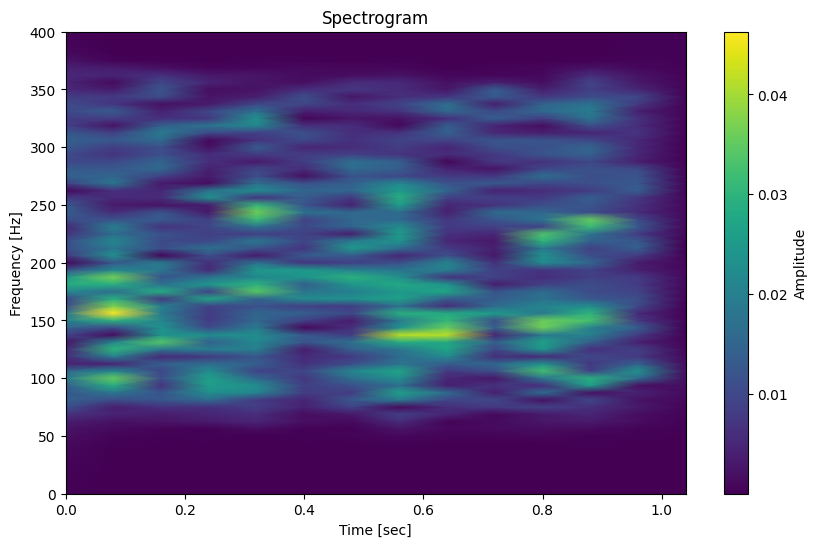

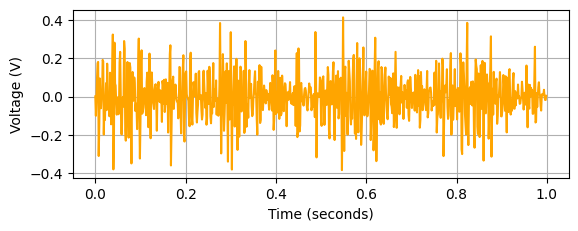

In [360]:
current_array = scratch_data_800Hz[100:900]
# print(rest_data_400Hz.shape)
cleaned = cleanup(current_array)
cleaned = tf.convert_to_tensor(cleaned, dtype=tf.float32)
f, t, spec = stft_full(cleaned, sampling_rate=800)
s = get_spectrogram(cleaned)
# print(f, t)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, s, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Amplitude')  # limit frequency range to make plot clearer
plt.savefig('scratch_data_800Hz.png')
plt.show()


time = np.arange(len(current_array)) / 800.0  

plt.subplot(2, 1, 2)
plt.plot(time, cleaned, label='Centered EMG Voltage', color='orange')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (seconds)')

plt.grid(True)

In [ ]:
# helper functions to train the model

def get_sample(data, start, sampling_rate=800):
    end = start + sampling_rate
    return data[start:end]

def get_data(filepath):
    df = pd.read_csv(filepath)
    return df[['v1', 'v2', 'label']].to_numpy()

def clean_data(data: np.ndarray):
    v1 = data[:, 0]
    v2 = data[:, 1]
    labels = data[:, 2]

    v1_cleaned = cleanup(v1)
    v2_cleaned = cleanup(v2)

    return np.column_stack((v1_cleaned, v2_cleaned, labels))

def get_spectrograms(data: np.ndarray, sampling_rate=800, verbose=False):

    v1 = data[:, 0]
    v2 = data[:, 1]
    labels = data[:, 2]

    num_samples = data.shape[0]

    all_spec = []
    all_labels = []

    for i in range(0, (num_samples - sampling_rate) + 1, int(sampling_rate / 2)):
        
        sample1 = get_sample(v1, i, sampling_rate)
        sample2 = get_sample(v2, i, sampling_rate)

        if verbose:
            print(f"Processing sample {i} to {i + sampling_rate}")
            # print(sample1, sample2)
        
        # print(sample1.shape, sample2.shape)
        sample1 = tf.convert_to_tensor(sample1, dtype=tf.float32)
        sample2 = tf.convert_to_tensor(sample2, dtype=tf.float32)

        spec1 = get_spectrogram(sample1)
        spec2 = get_spectrogram(sample2)
        
        sample = tf.stack([spec1, spec2], axis=1)
        all_spec.append(sample)
        all_labels.append(tf.cast(labels[i], tf.int32))

    # print(all_spec, all_labels)

    return tf.stack(all_spec, axis=0), tf.stack(all_labels, axis=0)

def split_data(data: np.ndarray, split_ratio=0.8):
    num_samples = data.shape[0]
    split_index = int(num_samples * split_ratio)
    
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data


In [442]:
# training on 5 seconds of data

scratch_data = get_data('data\\800Hz\\emg_scratch_800Hz.csv')
rest_data = get_data('data\\800Hz\\emg_rest_800Hz.csv')
other_data = get_data('data\\800Hz\\emg_other_800Hz.csv')

scratch_data = clean_data(scratch_data)
rest_data = clean_data(rest_data)
other_data = clean_data(other_data)
# print(scratch_df.shape)

# split into training and validation
df_scratch_train, df_scratch_test = split_data(scratch_data)
df_rest_train, df_rest_test = split_data(rest_data)
df_other_train, df_other_test = split_data(other_data)

specs, labels = get_spectrograms(scratch_data, verbose=True)
df_scratch_train

Processing sample 0 to 800
Processing sample 400 to 1200
Processing sample 800 to 1600
Processing sample 1200 to 2000
Processing sample 1600 to 2400
Processing sample 2000 to 2800
Processing sample 2400 to 3200
Processing sample 2800 to 3600
Processing sample 3200 to 4000


array([[ 3.70022987e-04,  3.21993852e-04,  1.00000000e+00],
       [ 3.29229167e-02,  6.74348979e-03,  1.00000000e+00],
       [-1.45799235e-02,  2.06762681e-02,  1.00000000e+00],
       ...,
       [-6.75248510e-02, -2.76330204e-03,  1.00000000e+00],
       [-7.17688028e-02, -3.17874295e-02,  1.00000000e+00],
       [ 1.06156521e-01, -2.21498624e-02,  1.00000000e+00]])

In [443]:
scratch_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_scratching_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_scratching_raina.csv')])

rest_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_rest_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_rest_raina.csv')])

other_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_other_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_other_raina.csv')])

print(scratch_data.shape, rest_data.shape, other_data.shape)

scratch_data = clean_data(scratch_data)
rest_data = clean_data(rest_data)   
other_data = clean_data(other_data)

# print(scratch_data)

df_scratch_train, df_scratch_test = split_data(scratch_data)
df_rest_train, df_rest_test = split_data(rest_data)
df_other_train, df_other_test = split_data(other_data)

(667000, 3) (667000, 3) (667000, 3)


In [444]:
# dataset manipulation bit
spec_scratch_train, scratch_labels = get_spectrograms(df_scratch_train, sampling_rate=1000)
spec_rest_train, rest_labels = get_spectrograms(df_rest_train, sampling_rate=1000)
spec_other_train, other_labels = get_spectrograms(df_other_train, sampling_rate=1000)

spec_scratch_test, scratch_labels_test = get_spectrograms(df_scratch_test, sampling_rate=1000)
spec_rest_test, rest_labels_test = get_spectrograms(df_rest_test, sampling_rate=1000)
spec_other_test, other_labels_test = get_spectrograms(df_other_test, sampling_rate=1000)

print(spec_scratch_train[0].shape)

ds_scratch_train = tf.data.Dataset.from_tensor_slices((spec_scratch_train, scratch_labels))
ds_rest_train = tf.data.Dataset.from_tensor_slices((spec_rest_train, rest_labels))
ds_other_train = tf.data.Dataset.from_tensor_slices((spec_other_train, other_labels))

ds_scratch_test = tf.data.Dataset.from_tensor_slices((spec_scratch_test, scratch_labels_test))
ds_rest_test = tf.data.Dataset.from_tensor_slices((spec_rest_test, rest_labels_test))
ds_other_test = tf.data.Dataset.from_tensor_slices((spec_other_test, other_labels_test))

spec_all_train = tf.concat([spec_scratch_train, spec_rest_train, spec_other_train], axis=0)
label_all_train = tf.concat([scratch_labels, rest_labels, other_labels], axis=0)

spec_all_test = tf.concat([spec_scratch_test, spec_rest_test, spec_other_test], axis=0)
label_all_test = tf.concat([scratch_labels_test, rest_labels_test, other_labels_test], axis=0)

complete_training_set = ds_scratch_train.concatenate(ds_rest_train).concatenate(ds_other_train)
complete_test_set = ds_scratch_test.concatenate(ds_rest_test).concatenate(ds_other_test)



(65, 2, 17)


In [445]:
for spectrogram, label in complete_training_set.take(1):
    print("Spectrogram shape:", spectrogram.shape)
    print("Label:", label.numpy())

Spectrogram shape: (65, 2, 17)
Label: 1


In [467]:
input_shape = spec_all_train[0].shape

norm_layer = Normalization()
norm_layer.adapt(ds_scratch_train.map(lambda x, _: x))

size = tf.data.experimental.cardinality(complete_test_set).numpy()
print("Dataset size:", size)

size = tf.data.experimental.cardinality(complete_training_set).numpy()
print("Dataset size:", size)

batch_size = 32
train_ds = complete_training_set.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = complete_test_set.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Training dataset size:", val_ds)

model = models.Sequential([
    layers.Input(shape=input_shape),
    Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)  # Assuming 3 classes: scratch, rest, other
])

model.summary()

Dataset size: 795
Dataset size: 3198
Training dataset size: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 65, 2, 17), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_43 (Resizing)          │ (None, 32, 32, 17)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_50                │ (None, 32, 32, 17)     │            35 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 30, 30, 32)     │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,606 (6.22 MB)

 Trainable params: 1,629,571 (6.22 MB)

 Non-trainable params: 35 (144.00 B)

In [470]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [471]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6318 - loss: 8.2859 - val_accuracy: 0.6277 - val_loss: 0.9903
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6280 - loss: 0.9908 - val_accuracy: 0.6340 - val_loss: 1.1139
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6421 - loss: 0.7731 - val_accuracy: 0.6239 - val_loss: 1.0479
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6978 - loss: 0.7447 - val_accuracy: 0.6252 - val_loss: 1.3861
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8427 - loss: 0.4331 - val_accuracy: 0.6025 - val_loss: 1.0395
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8815 - loss: 0.3816 - val_accuracy: 0.6478 - val_loss: 1.4057
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9223 - loss: 0.2111 - val_accuracy: 0.6591 - val_loss: 1.5565
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9286 - loss: 0.2164 - val_accu

In [472]:
model.save('first_9412_accuracy.keras')

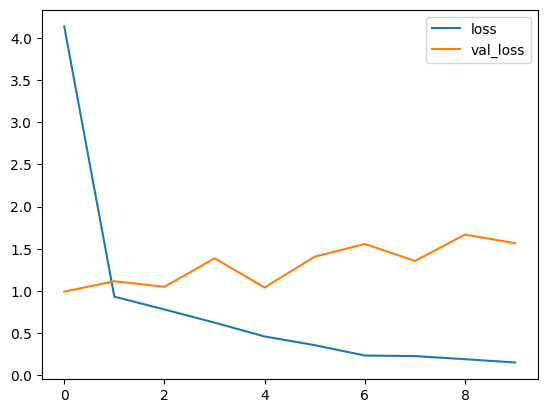

In [473]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig('loss_plot_9412.png')
plt.show()

In [481]:
val_ds = complete_test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

y_pred = np.argmax(model.predict(val_ds.map(lambda x, y: x)), axis=1)
y_labels = label_all_test.numpy()

test_acc = sum(y_pred == y_labels) / len(y_pred)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test set accuracy: 67%


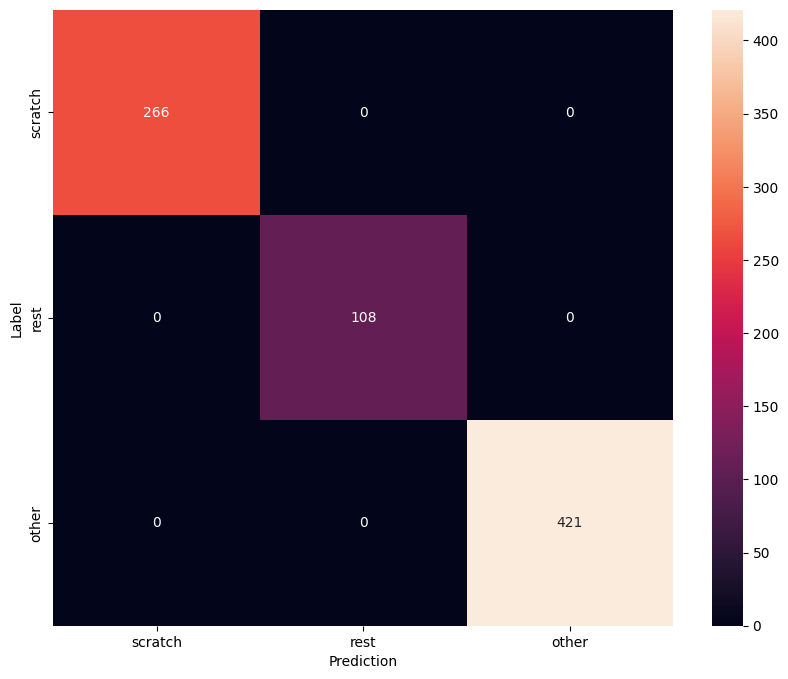

In [476]:
commands = ['scratch', 'rest', 'other']
confusion_mtx = tf.math.confusion_matrix(y_pred, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [478]:
model = tf.keras.models.load_model("first_9412_accuracy.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\aryan\AppData\Local\Temp\tmp29k9lnw9\assets


INFO:tensorflow:Assets written to: C:\Users\aryan\AppData\Local\Temp\tmp29k9lnw9\assets


Saved artifact at 'C:\Users\aryan\AppData\Local\Temp\tmp29k9lnw9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 65, 2, 17), dtype=tf.float32, name='input_layer_47')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1961271887440: TensorSpec(shape=(1, 1, 17), dtype=tf.float32, name=None)
  1961271888976: TensorSpec(shape=(1, 1, 17), dtype=tf.float32, name=None)
  1958524888912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524890064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524891216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524889680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524887376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524892752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524893904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1958524891984: TensorSpec(shape=(), dtype=tf.resource, name